In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Tuple, Dict, Optional, Any
from scipy.stats import ttest_ind, levene, ks_2samp

In [86]:
from annealing_ab.algo.annealing_ab import AnnealingAB
from annealing_ab.loss.losses import TTestLoss, KSLoss, LeveneLoss
from annealing_ab.analysis.charts import FeatureDistributionVisualizer
from annealing_ab.analysis.results import MultiCriteriaEvaluator

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
def _generate_feature_values(n: int, distribution_type: str, params: Dict[str, float]) -> np.ndarray:
    """Generates feature values with given distribution."""
    if distribution_type == 'normal':
        return np.random.normal(params['loc'], params['scale'], n)
    elif distribution_type == 'lognormal':
        return np.random.lognormal(params['mean'], params['sigma'], n)
    elif distribution_type == 'uniform':
        return np.random.uniform(params['low'], params['high'], n)
    elif distribution_type == 'beta':
        return np.random.beta(params['a'], params['b'], n)
    elif distribution_type == 'gamma':
        return np.random.gamma(params['shape'], params['scale'], n)
    elif distribution_type == 'exponential':
        return np.random.exponential(params['scale'], n)
    else:
        raise ValueError(f"Unsupported distribution type: {distribution_type}")

In [5]:
def generate_synthetic_data_subset(
    n_general: int = 1000,
    n_target: int = 200,
    n_features: int = 5,
    feature_types: Dict[str, Any] = None,
    random_state: Optional[int] = None
) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """
    Generates synthetic data where the target population is a subset of the general population.
    
    Returns:
        general_df_minus_target, general_df, target_df
    """
    if random_state is not None:
        np.random.seed(random_state)
    
    # Default feature types
    if feature_types is None:
        feature_types = {
            'age': {'type': 'normal', 'params': {'loc': 35, 'scale': 10}},
            'income': {'type': 'lognormal', 'params': {'mean': 4, 'sigma': 0.8}},
            'education_years': {'type': 'uniform', 'params': {'low': 8, 'high': 20}},
            'satisfaction': {'type': 'beta', 'params': {'a': 2, 'b': 5}},
            'engagement': {'type': 'gamma', 'params': {'shape': 2, 'scale': 1}}
        }
    
    feature_names = list(feature_types.keys())[:n_features]
    
    # Генерируем генеральную совокупность
    general_data = {}
    for feature_name in feature_names:
        feature_config = feature_types[feature_name]
        general_data[feature_name] = _generate_feature_values(
            n_general, feature_config['type'], feature_config['params']
        )
    
    # Добавляем user_id
    general_data['user_id'] = [i for i in range(n_general)]
    
    general_df = pd.DataFrame(general_data)
    
    # Выбираем таргет как случайное подмножество
    target_df = general_df.sample(n=n_target, random_state=random_state).copy()
    
    # Убираем таргет из генеральной совокупности
    general_minus_target_df = general_df.drop(target_df.index).reset_index(drop=True)
    target_df = target_df.reset_index(drop=True)
    
    return general_minus_target_df, general_df, target_df

In [15]:
def compare_feature_distributions(
    df1: pd.DataFrame,
    df2: pd.DataFrame,
    fk_key: str
) -> pd.DataFrame:
    """
    Computes p-values for t-test, Levene test, and KS test for each feature.
    
    Parameters
    ----------
    df1 : pd.DataFrame
        First dataframe (e.g., general population)
    df2 : pd.DataFrame
        Second dataframe (e.g., target population)
    fk_key : str
        Column name with unique IDs to ignore in tests
    
    Returns
    -------
    pd.DataFrame
        DataFrame with feature names and corresponding p-values
    """
    features = [col for col in df1.columns if col != fk_key]
    
    results = []
    for feat in features:
        x = df1[feat].to_numpy()
        y = df2[feat].to_numpy()
        
        t_stat, t_p = ttest_ind(x, y, equal_var=False)
        
        lev_stat, lev_p = levene(x, y, center='mean')
        
        ks_stat, ks_p = ks_2samp(x, y)
        
        results.append({
            'feature': feat,
            'ttest_pvalue': t_p,
            'levene_pvalue': lev_p,
            'ks_pvalue': ks_p
        })
    
    return pd.DataFrame(results)

In [6]:
gen, _, target = generate_synthetic_data_subset(
    n_general=1000,
    n_target=200,
    n_features=8,
)

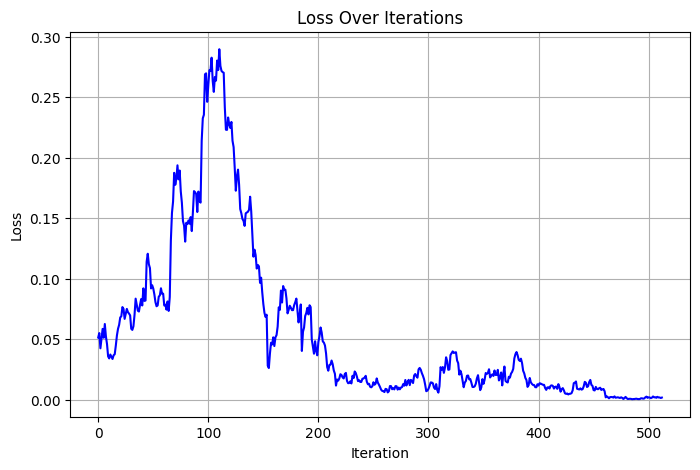

feature  ttest_pvalue  levene_pvalue  ks_pvalue
0              age      0.815755       0.170550   0.466286
1           income      0.858894       0.372680   0.466286
2  education_years      0.811710       0.208042   0.793362
3     satisfaction      0.825789       0.411886   0.987790
4       engagement      0.626560       0.721855   0.964652

In [81]:
ttest = TTestLoss(X=gen, Y=target)

annealer = AnnealingAB(
    general_population=gen,
    target_population=target,
    test_stats_criteria=ttest,
    fk_key='user_id',
    n_sub=200,
    num_groups=2,
    temperature=1,
    cooling_rate=0.99,
    min_temperature=1e-3,
    max_iterations=2000,
    random_state=42,
    early_stop_k=60,
    early_stop_eps=1e-2
)

subset = annealer.run()
annealer.loss_chart()
compare_feature_distributions(target, subset, fk_key='user_id')

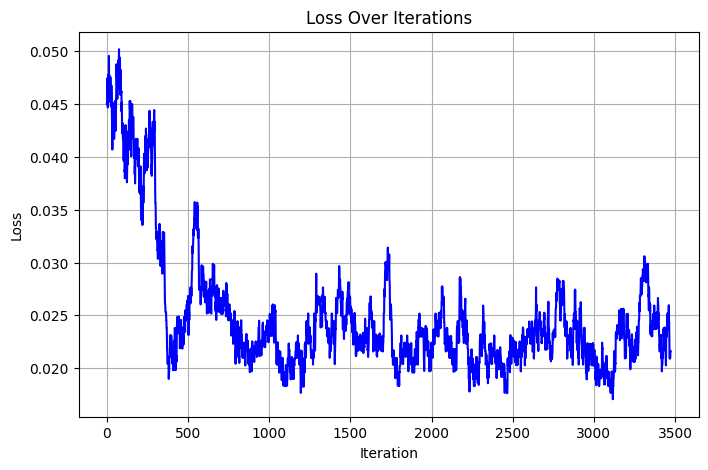

feature  ttest_pvalue  levene_pvalue  ks_pvalue
0              age      0.808067       0.643445   0.987790
1           income      0.823953       0.651695   0.987790
2  education_years      0.885163       0.918985   0.964652
3     satisfaction      0.947623       0.405582   0.964652
4       engagement      0.996206       0.714165   0.964652

In [83]:
ksloss = KSLoss(X=gen, Y=target)

annealer = AnnealingAB(
    general_population=gen,
    target_population=target,
    test_stats_criteria=ksloss,
    fk_key='user_id',
    n_sub=200,
    num_groups=2,
    temperature=1,
    cooling_rate=0.98,
    min_temperature=1e-3,
    max_iterations=5000,
    random_state=42,
    early_stop_k=60,
    early_stop_eps=1e-5
)

subset = annealer.run()
annealer.loss_chart()
compare_feature_distributions(target, subset, fk_key='user_id')

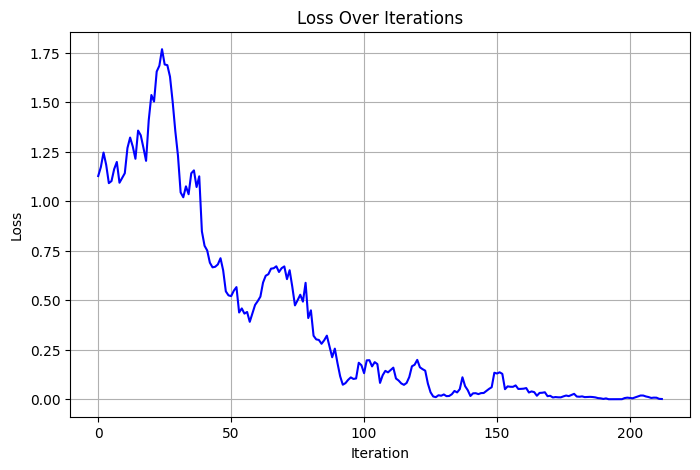

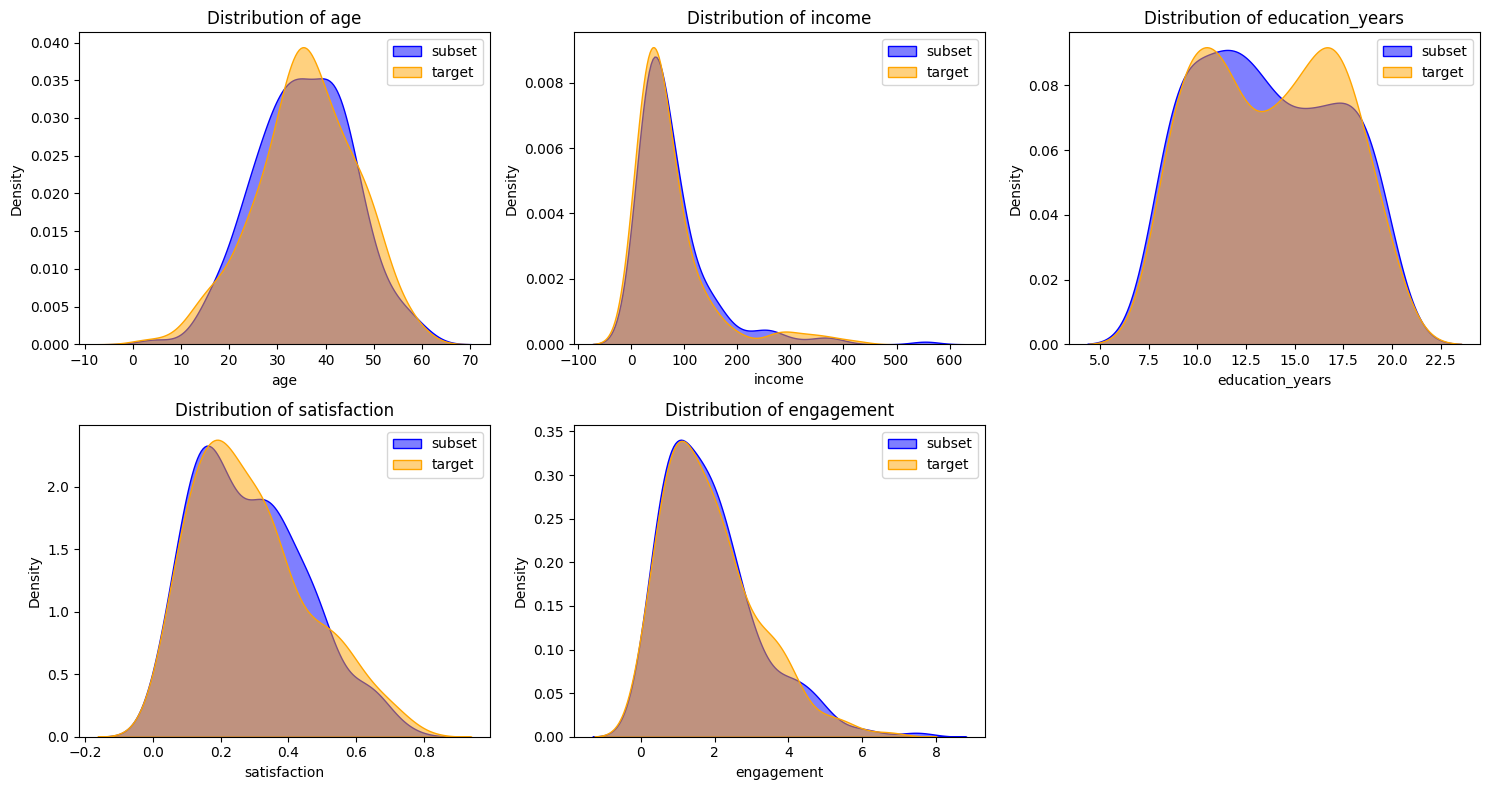

In [91]:
levene_loss = LeveneLoss(X=gen, Y=target)

annealer = AnnealingAB(
    general_population=gen,
    target_population=target,
    test_stats_criteria=levene_loss,
    fk_key='user_id',
    n_sub=200,
    num_groups=2,
    temperature=1,
    cooling_rate=0.98,
    min_temperature=1e-3,
    max_iterations=5000,
    random_state=42,
    early_stop_k=60,
    early_stop_eps=1e-1
)

subset = annealer.run()
annealer.loss_chart()
annealer.distribution_chart(plot_type="kde")

In [92]:
annealer.criteria_stats_report()

feature     ttest        KS        levene
0              age  0.004060  0.030313  1.122123e-04
1           income  0.032255  0.047168  1.071733e-03
2  education_years  0.004864  0.038401  2.295406e-07
3     satisfaction  0.000122  0.022939  4.424928e-03
4       engagement  0.000002  0.019535  1.661834e-03